In [109]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/novozymes-enzyme-stability-prediction/sample_submission.csv
/kaggle/input/novozymes-enzyme-stability-prediction/wildtype_structure_prediction_af2.pdb
/kaggle/input/novozymes-enzyme-stability-prediction/train.csv
/kaggle/input/novozymes-enzyme-stability-prediction/test.csv
/kaggle/input/novozymes-enzyme-stability-prediction/train_updates_20220929.csv


This notebook uses the pretrained language models ProtTrans [Link](https://github.com/agemagician/ProtTrans). ProtTrans was trained on thousands of GPUs from Summit and hundreds of Google TPUs using Transformers Models.

1. Load necessry libraries including huggingface and bertvis transformers

In [3]:
import re
import os
import random
import pickle
import math
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
# from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import TFBertForMaskedLM, BertTokenizer
from matplotlib import rcParams
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
# Scipy's implementation of Spearman's Rho 
from scipy.stats import spearmanr
seed = 42

In [4]:
%%capture
!pip install torchmetrics
!pip install pytorch-nlp
!pip install -q transformers
!git clone https://github.com/jessevig/bertviz.git

In [5]:
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
seed_everything(1234)

In [6]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv("test.csv")
sample = pd.read_csv('sample_submission.csv')

print(f"train_shape:{df_train.shape},test_shape:{df_test.shape},Sample_shape:{sample.shape}")

train_shape:(31390, 5),test_shape:(2413, 4),Sample_shape:(2413, 2)


In [7]:
# Make corrections to data 2409 rows, with all features marked as NaN), 
# as well as the rows where the pH and tm were transposed 
# (25 rows, with corrected features in this dataset)

import pandas as pd

df_train_updates = pd.read_csv("train_updates_20220929.csv", index_col="seq_id")

all_features_nan = df_train_updates.isnull().all("columns")

drop_indices = df_train_updates[all_features_nan].index
df_train = df_train.drop(index=drop_indices)

swap_ph_tm_indices = df_train_updates[~all_features_nan].index
df_train.loc[swap_ph_tm_indices, ["pH", "tm"]] = df_train_updates.loc[swap_ph_tm_indices, ["pH", "tm"]]

In [8]:
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])

Metal device set to: Apple M1 Pro
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2022-11-22 02:56:36.270486: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-22 02:56:36.270896: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
BATCH_SIZE = 16*strategy.num_replicas_in_sync
BUFFER_SIZE = 5000
AUTO = tf.data.AUTOTUNE
EPOCHS = 100
MAX_LEN = 512
PAD_TYPE = 'post'
TRUNC_TYPE = 'post'
CHECKPOINT_PATH = 'mymodel.h5'

In [10]:
def preprocess(data):
    seq = " ".join("".join(data.split()))
    seq = re.sub(r"[UZOB]", "X", seq)

    return seq

In [11]:
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert")
print(f"{tokenizer.get_vocab()}")

{'[PAD]': 0, '[UNK]': 1, '[CLS]': 2, '[SEP]': 3, '[MASK]': 4, 'L': 5, 'A': 6, 'G': 7, 'V': 8, 'E': 9, 'S': 10, 'I': 11, 'K': 12, 'R': 13, 'D': 14, 'T': 15, 'P': 16, 'N': 17, 'Q': 18, 'F': 19, 'Y': 20, 'M': 21, 'H': 22, 'C': 23, 'W': 24, 'X': 25, 'U': 26, 'B': 27, 'Z': 28, 'O': 29}


In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(df_train['protein_sequence'], df_train['tm'], test_size=0.15, random_state=42)

In [13]:
def prot_encode(texts, tokenizer, max_len = MAX_LEN):
    input_ids = np.zeros((len(texts), max_len), dtype="int32")
    #token_type_ids = np.zeros((len(texts), max_len), dtype="int32")
    attention_mask = np.zeros((len(texts), max_len), dtype="int32")
    
    for i, text in enumerate(texts):
        text = preprocess(text)
        token = tokenizer(text, 
                          max_length         = max_len, 
                          truncation         = True, 
                          padding            = "max_length",
                          add_special_tokens = True,
                          return_tensors     = "np")
        
        input_ids[i] = token['input_ids']
        #token_type_ids[i] = token['token_type_ids']
        attention_mask[i] = token['attention_mask']
    return input_ids, attention_mask   #token_type_ids, 

In [14]:
X_train = prot_encode(X_train.astype(str), tokenizer)
X_valid = prot_encode(X_valid.astype(str), tokenizer)

y_train = y_train.values
y_valid = y_valid.values

In [15]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_train, y_train))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_valid, y_valid))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

In [16]:
for x, y in train_dataset.take(1):
    print(x)
    print(y)

(<tf.Tensor: shape=(32, 512), dtype=int32, numpy=
array([[ 2, 21, 10, ...,  0,  0,  0],
       [ 2, 21,  6, ...,  0,  0,  0],
       [ 2, 21, 10, ...,  0,  0,  0],
       ...,
       [ 2, 21,  9, ...,  0,  0,  0],
       [ 2, 21, 10, ...,  0,  0,  0],
       [ 2, 21, 17, ..., 10, 11,  3]], dtype=int32)>, <tf.Tensor: shape=(32, 512), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int32)>)
tf.Tensor(
[47.6 56.  46.5 53.5 49.6 40.3 51.9 45.9 88.9 49.6 41.6 43.9 61.  54.
 47.5 41.1 64.7 44.8 49.7 45.6 89.1 53.8 55.2 46.4 47.2 57.7 46.7 32.5
 43.8 75.9 35.7 40.3], shape=(32,), dtype=float64)


In [17]:
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(CHECKPOINT_PATH,
                                                           monitor='val_loss',
                                                           save_best_only=True,
                                                           save_weights_only=True)

earlystop_callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=10,
                                                  verbose=1)

reducelr_callback = keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                     factor=0.2,
                                                     patience=5,
                                                     verbose=1)

In [18]:
def build_model(trainable=False,max_len=512):
    base_model = TFBertForMaskedLM.from_pretrained("Rostlab/prot_bert", from_pt=True)
    base_model.trainable = trainable
    input_ids = keras.Input(shape=(max_len,), dtype=tf.int32, name="input_ids")

    attention_mask = keras.Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
    base_output = base_model.bert(input_ids=input_ids,attention_mask=attention_mask)
    last_hidden_state = base_output[0]
    x = layers.GlobalAveragePooling1D()(last_hidden_state)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.15)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(1)(x)
    model = keras.Model(inputs=[input_ids, attention_mask], outputs=outputs)
    return model

In [21]:
tf.keras.backend.clear_session()
with strategy.scope():
    
    model = build_model(trainable=True)  # freeze base model

    model.compile(optimizer=keras.optimizers.Adam(2e-5),
                loss=keras.losses.MeanSquaredError(),
                metrics=[keras.losses.MeanAbsoluteError()])

model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForMaskedLM: ['cls.predictions.decoder.bias']
- This IS expected if you are initializing TFBertForMaskedLM from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForMaskedLM from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertForMaskedLM were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  418881536   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

In [ ]:
callbacks = [ 
    model_checkpoint_callback,
    earlystop_callback,
    reducelr_callback,
]

history = model.fit(train_dataset,
                    validation_data=valid_dataset,
                    epochs=3,
                    callbacks=callbacks,
                    steps_per_epoch=y_train.shape[0]//BATCH_SIZE,
                   )

Epoch 1/3


2022-11-22 03:13:27.217471: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_3"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
input: "Placeholder/_2"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
      type: DT_INT32
      type: DT_DOUBLE
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 24633
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 512
        }
      }
      shape {
        dim {
          size: 512
        }
      }
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {


 48/769 [>.............................] - ETA: 49:52:36 - loss: 2429.0208 - mean_absolute_error: 47.9008

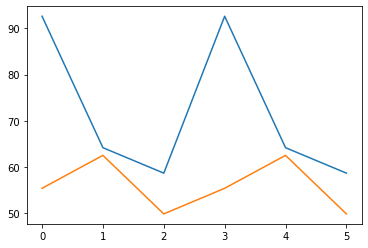

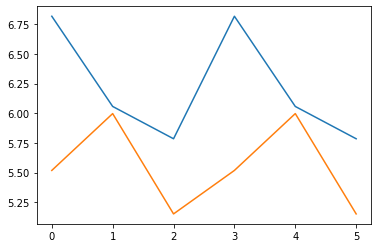

In [128]:
loss = history.history['loss']
epoch = range(len(loss) + len(history.history["loss"]))

plt.plot(epoch, history.history['loss']+history.history["loss"])
plt.plot(epoch, history.history['val_loss']+history.history["val_loss"])

plt.figure()
plt.plot(epoch, history.history['mean_absolute_error']+history.history["mean_absolute_error"])
plt.plot(epoch, history.history['val_mean_absolute_error']+history.history["val_mean_absolute_error"])

# Submission

In [129]:
model.load_weights(CHECKPOINT_PATH)

In [130]:
X_test = prot_encode(df_test['protein_sequence'].astype(str), tokenizer)

In [131]:
predictions = model.predict(X_test,verbose=1)

2022-11-22 10:44:43.912968: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_408924"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy = Aut

76/76 [==============================] - 204s 2s/step


In [132]:
submission_df = pd.DataFrame()
submission_df["seq_id"] = df_test["seq_id"]
submission_df["tm"] = predictions
submission_df.to_csv("submission.csv", index=False)
pd.read_csv('submission.csv')

,seq_id,tm
0,31390,52.009064
1,31391,52.202170
2,31392,53.034683
3,31393,52.172737
4,31394,53.969177
...,...,...
2408,33798,54.248596
2409,33799,52.929880
2410,33800,52.971510
2411,33801,52.859947
